In [1]:
from HeaderP import *

In [2]:
import Astraea

In [3]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# predict rbirth with Minchev 2018

## Get present day metallicity gradient and gradient with time in the Solar neighborhood

In [124]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=2


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)

In [125]:
len(data)

7315685

In [126]:
import random

SolarRad=8.2*(5./3.)

def getbin(x,y,binnumb=100):
    xbin=np.linspace(min(x),max(x),binnumb)
    x_bin=((max(x)-min(x))/binnumb)/2+xbin[:-1]
    y_bin=np.zeros(len(x_bin))
    for i in range(len(x_bin)):
        m=(x>xbin[i])&(x<xbin[i+1])
        y_bin[i]=np.median(y[m])
    return x_bin, y_bin
    

def get_SR(feh, x, y,xbir,ybir, radius=0.2*(5./3.), plotpoints=False):
    # radius: how big the solar circle is...
    
    # generate random location of the sun
    x_sun=random.uniform(-SolarRad, SolarRad)
    y_sun=np.sqrt(SolarRad**2.-x_sun**2.)*np.random.choice([-1,1])
    
    # get stars in the solar circle
    m=(((x-x_sun)**2.+(y-y_sun)**2.)<radius**2.)
    
    feh_sr, x_sr, y_sr = feh[m], xbir[m], ybir[m]
    
    r_sr=np.sqrt(x[m]**2. + y[m]**2.)
    
    if plotpoints:
        plt.figure()
        plt.plot(xbir,ybir,'k.',markersize=0.01,alpha=0.5)
        plt.plot(x_sr, y_sr,'r.',markersize=5)
        plt.xlabel('xbir')
        plt.ylabel('ybir')
        plt.legend()
        
    return feh_sr, r_sr, m


def calc_dfedr_SR(feh, r, plotpoints=False):
    r_bin, feh_bin = getbin(r, feh, binnumb=100)
    p = fitpoints(r_bin,feh_bin)
    if plotpoints:
        plt.figure()
        plt.plot(r_bin,feh_bin,'k.',markersize=5)
        plt.plot([min(r_bin),max(r_bin)],p([min(r_bin),max(r_bin)]),'r-',label='Gradient = %.4f'%(p[1]))
        plt.xlabel('R')
        plt.ylabel('[Fe/H]')
        plt.legend()
    return p[1]

No handles with labels found to put in legend.


-0.06371847407820108


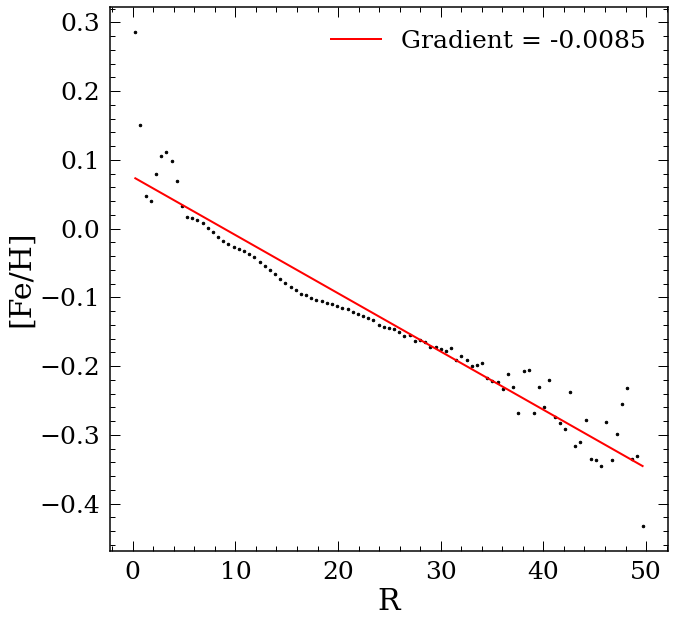

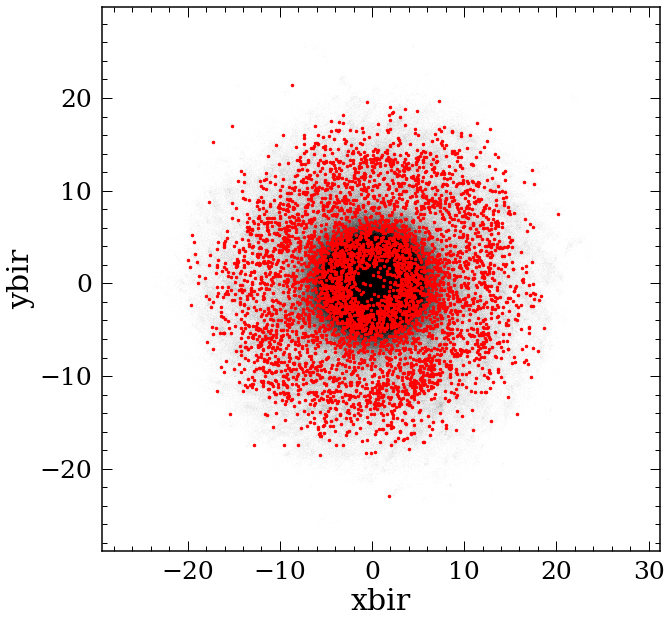

In [148]:
radtotest=1
# present day metallicity gradient
p=calc_dfedr_SR(data['feh_scale'].values,data['R'].values,plotpoints=True)

# present day metallicity in the solar neighborhood
feh_sr, r_sr, m_sr = get_SR(data['feh_scale'].values, data['x'].values, data['y'].values,
                            data['x_birth'].values,data['y_birth'].values,radius=radtotest,plotpoints=True)


srm=(abs(data['R']-SolarRad)<radtotest)
feh_p = np.median(data['feh_scale'][srm])
print(feh_p)


Text(0.5, 0, '[Fe/H]')

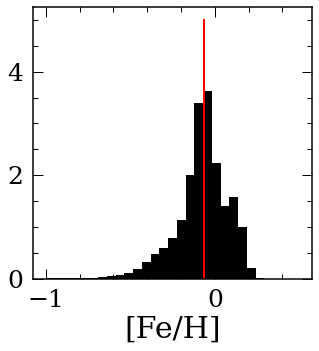

In [149]:
plt.figure(figsize=(5,5))
plt.hist(data['feh_scale'][srm],bins=np.linspace(-1,0.5,30),color='k',density=True)
plt.plot([feh_p,feh_p],[0,5],'r-')
plt.xlabel('[Fe/H]')

## optimize with MCMC

In [181]:
currentt=0.05
slopet=0.05
slopenorm=3

def getfeh_sr(t):
    return currentt*np.log(14-t)-currentt*np.log(14)+feh_p

def getfeh_slope(t):
    return slopet*(math.log(15-t,slopenorm))+p-slopet*(math.log(15,slopenorm))

def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]


In [182]:
ages_sr = data['age'][m_sr].values
r_birth_true = data['R_bir'][m_sr].values
print(len(r_birth_true),len(ages_sr))

4959 4959


(14.0, 0.0)

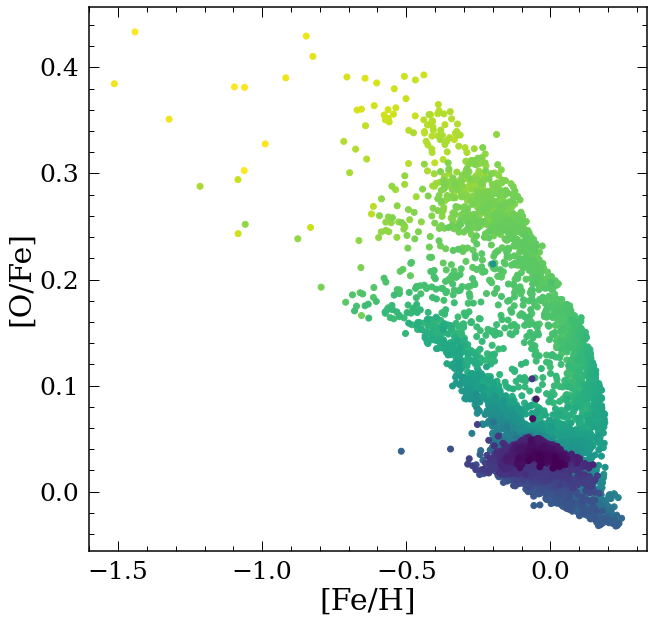

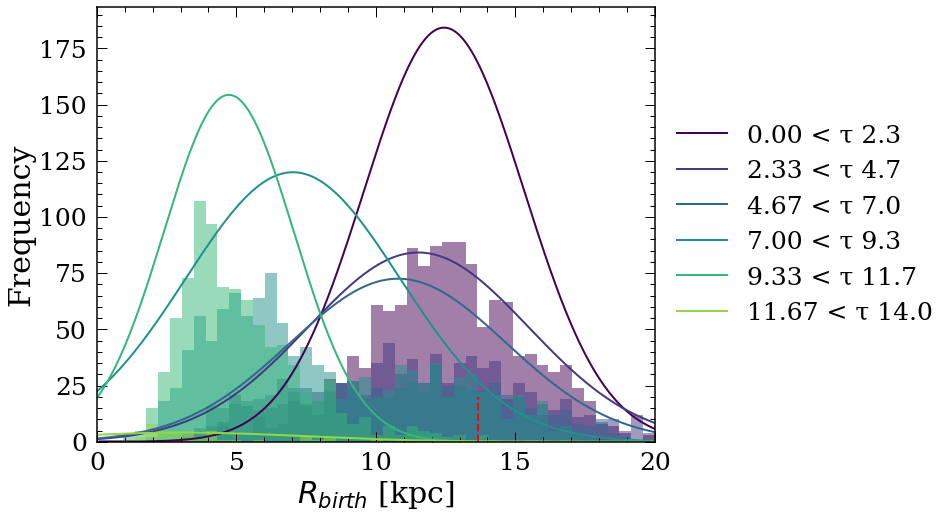

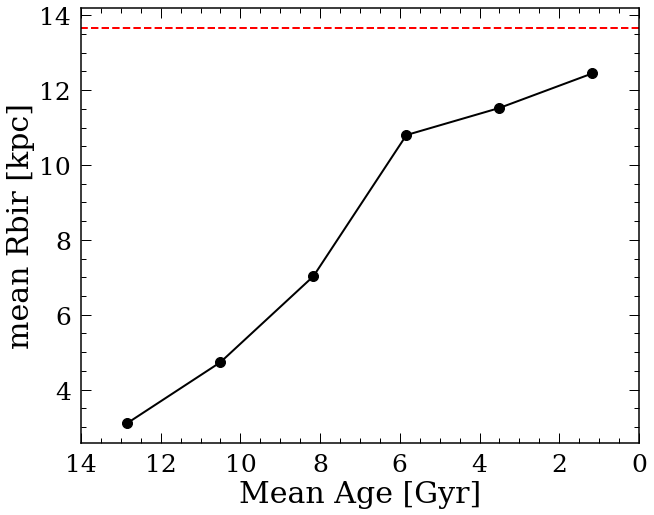

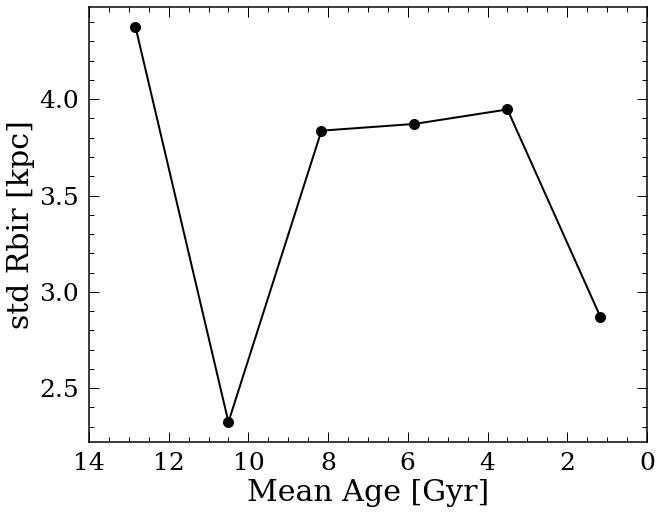

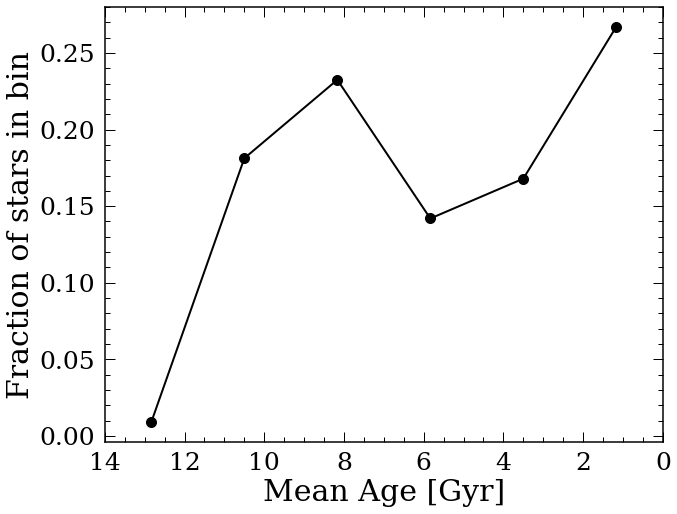

In [183]:
numbofbins=6
plt.scatter(feh_sr,data['ofe_scale'][m_sr],c=data['age'][m_sr])
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')

import seaborn as sns
import matplotlib
# historgram of mono-age population
plt.figure(figsize=(10,8))
agebin=np.linspace(0,14,numbofbins+1)
colors_feh = getcolor(agebin)

meanrbirth = np.zeros(numbofbins)
stdbirth = np.zeros(numbofbins)
numbstars = np.zeros(numbofbins)
for i in range(len(agebin)-1):
    
    m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    plt.hist(r_birth_true[m], color=colors_feh[i], bins=np.linspace(-5,20,60), alpha=0.5)
    meanrbirth[i]=np.median(r_birth_true[m])
    stdbirth[i]=np.std(r_birth_true[m])
    gausd=sum(m)/(np.std(r_birth_true[m]) * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(-5,20,1000) - np.median(r_birth_true[m]))**2 / (2 * np.std(r_birth_true[m])**2))
    numbstars[i]=sum(m)
    plt.plot(np.linspace(-5,20,1000), gausd, color=colors_feh[i], label='%.2f < τ %.1f'%(agebin[i], agebin[i+1]))
    
plt.plot([SolarRad,SolarRad],[0,20],'r--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$R_{birth}$ [kpc]')
plt.ylabel('Frequency')
plt.xlim([0,20])


plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),meanrbirth,'ko-',markersize=10)
plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('mean Rbir [kpc]')
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),stdbirth,'ko-',markersize=10)
#plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('std Rbir [kpc]')
plt.xlim([14,0])

plt.figure(figsize=(10,8))
plt.plot((agebin[:-1]+np.diff(agebin)[0]/2),numbstars/sum(numbstars),'ko-',markersize=10)
#plt.plot([0,14],[SolarRad,SolarRad],'r--')
plt.xlabel('Mean Age [Gyr]')
plt.ylabel('Fraction of stars in bin')
plt.xlim([14,0])

In [184]:
SolarRad=8.2*(5./3.)
def feh_lookback(t):
    m=getfeh_slope(t)
    y=getfeh_sr(t)
    b=y-m*SolarRad
    return m, b

def get_chisq(para, feh, age, meanRbir, meanStd):
    m, b = para
    # put stars back into their birth raii
    rbirth_inf = (feh-b)/m
        
    return (np.median(rbirth_inf)-meanRbir)**2/meanRbir+(np.std(rbirth_inf)-meanStd)**2/meanStd


In [185]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

In [186]:
import emcee
import corner
# test for the first agebin
infer_slopes=np.zeros((numbofbins,3))
infer_feh=np.zeros((numbofbins,3))
int_disp=np.zeros((numbofbins,3))
nwalkers = 64
for i in trange(len(agebin)-1):
    m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    
    # get initial guess
    feh_sample, ages_sample = feh_sr[m], ages_sr[m]
    slope0 = getfeh_slope(np.mean(ages_sample))
    feh0 = getfeh_sr(np.mean(ages_sample))-slope0*SolarRad

    sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(feh_sample, ages_sample))
    p0 = np.array([slope0, feh0, np.log(0.03)])
    p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
    pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
    sampler_scatter.reset()
    sampler_scatter.run_mcmc(pos, 6000)
    samples_scatter = sampler_scatter.flatchain
    #tau = sampler_scatter.get_autocorr_time(c=4)

    mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
    infer_slopes[i,:] = mcmc[1], q[0], q[1]
    
    mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
    infer_feh[i,:] = infer_slopes[i,0]*SolarRad+mcmc[1], np.sqrt(infer_slopes[i,1]**2+q[0]**2), np.sqrt(infer_slopes[i,2]**2+q[1]**2)
    
    mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
    int_disp[i,:] = mcmc[1], q[0], q[1]


100%|██████████| 6/6 [01:24<00:00, 14.07s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

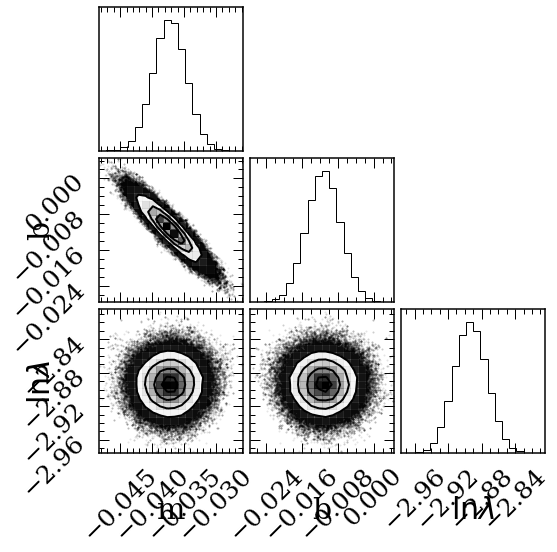

In [156]:
#### test the first bin 
import emcee
import corner
i=0
nwalkers = 64
m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    
# get initial guess
feh_sample, ages_sample = feh_sr[m], ages_sr[m]
slope0 = getfeh_slope(np.mean(ages_sample))
feh0 = getfeh_sr(np.mean(ages_sample))-slope0*SolarRad

sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(feh_sample, ages_sample))
p0 = np.array([slope0, feh0, np.log(0.03)])
p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
sampler_scatter.reset()
sampler_scatter.run_mcmc(pos, 6000)
samples_scatter = sampler_scatter.flatchain
tau = sampler_scatter.get_autocorr_time(c=4)

corner.corner(samples_scatter, labels=["m", "b", "$\ln\lambda$"]);

from IPython.display import display, Math

labels = ["m", "b", "ln(λ)"]
for i in range(3):
    mcmc = np.percentile(samples_scatter[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

[0.05540586 0.09716375 0.11900776 0.20207954 0.12806947 0.1533826 ]


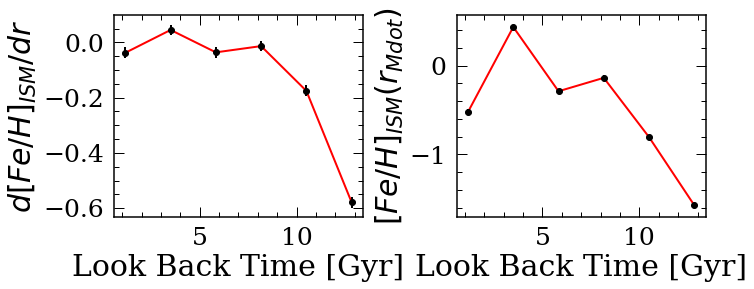

In [187]:
from scipy.interpolate import interp1d
# plot the results
print(np.exp(int_disp[:,0]))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
minagebin=min(agebin[:-1]+np.diff(agebin)[0]/2)
maxagebin=max(agebin[:-1]+np.diff(agebin)[0]/2)
#pslope=fitpoints(agebin[:-1]+np.diff(agebin)[0]/2,infer_slopes[:,0],order=3)
pslope=interp1d(agebin[:-1]+np.diff(agebin)[0]/2,infer_slopes[:,0])
plt.errorbar((agebin[:-1]+np.diff(agebin)[0]/2),infer_slopes[:,0],
             yerr=[infer_slopes[:,1],infer_slopes[:,2]],fmt='ko')
plt.plot(np.linspace(minagebin,maxagebin,100),pslope(np.linspace(minagebin,maxagebin,100)),'r-')

plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$d[Fe/H]_{ISM}/dr$')

plt.subplot(1,2,2)
#pfeh=fitpoints(agebin[:-1]+np.diff(agebin)[0]/2,infer_feh[:,0],order=3)
pfeh=interp1d(agebin[:-1]+np.diff(agebin)[0]/2,infer_feh[:,0])
plt.errorbar((agebin[:-1]+np.diff(agebin)[0]/2),infer_feh[:,0],
             yerr=[infer_feh[:,1],infer_feh[:,2]],fmt='ko')
plt.plot(np.linspace(minagebin,maxagebin,100),pfeh(np.linspace(minagebin,maxagebin,100)),'r-')
plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$[Fe/H]_{ISM}(r_{Mdot})$')

plt.tight_layout()

In [188]:
# get birth radii this way and plot against real birth radii
rbirth_inf = np.zeros(len(ages_sr))
for i in range(len(ages_sr)):
    # get relation
    if ages_sr[i]<minagebin:
        m = infer_slopes[0,0]
        b = infer_feh[0,0]-m*SolarRad
    elif ages_sr[i]>maxagebin:
        m = infer_slopes[-1,0]
        b = infer_feh[-1,0]-m*SolarRad
    else:
        m = pslope(ages_sr[i])
        b = pfeh(ages_sr[i])-m*SolarRad
    rbirth_inf[i] = (feh_sr[i]-b)/m


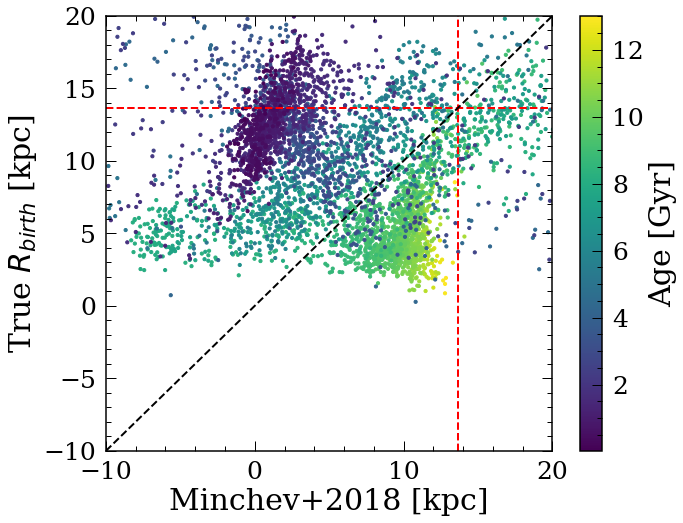

In [218]:
plt.figure(figsize=(10,8))
plt.scatter(rbirth_inf, r_birth_true, s=10, c = ages_sr)
plt.plot([SolarRad,SolarRad],[-10,20],'r--')
plt.plot([-10,20],[SolarRad,SolarRad],'r--')
plt.plot([-10,20],[-10,20],'k--')
plt.xlim([-10,20])
plt.ylim([-10,20])
plt.xlabel('Minchev+2018 [kpc]')
plt.ylabel('True $R_{birth}$ [kpc]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)

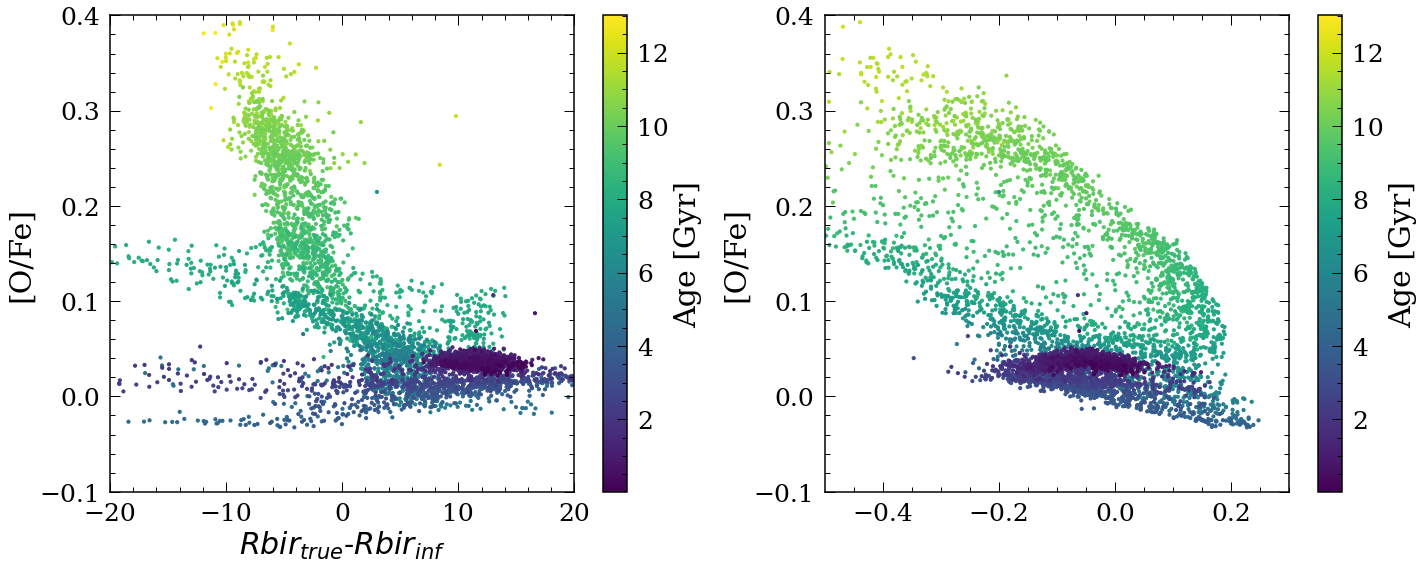

In [244]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(r_birth_true-rbirth_inf, data['ofe_scale'][m_sr].values, s=10, 
            c = data['age'][m_sr].values)
plt.xlim([-20,20])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.ylim([-0.1,0.4])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)

plt.subplot(1,2,2)
plt.scatter(data['feh_scale'][m_sr].values, data['ofe_scale'][m_sr].values, s=10, c = ages_sr)
plt.ylim([-0.1,0.4])
plt.xlim([-0.5,0.3])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)
plt.tight_layout()

<ipython-input-261-5d800c77f412>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sr['hi_low']=data_sr['ofe_scale']-p(data_sr['feh_scale'])>0


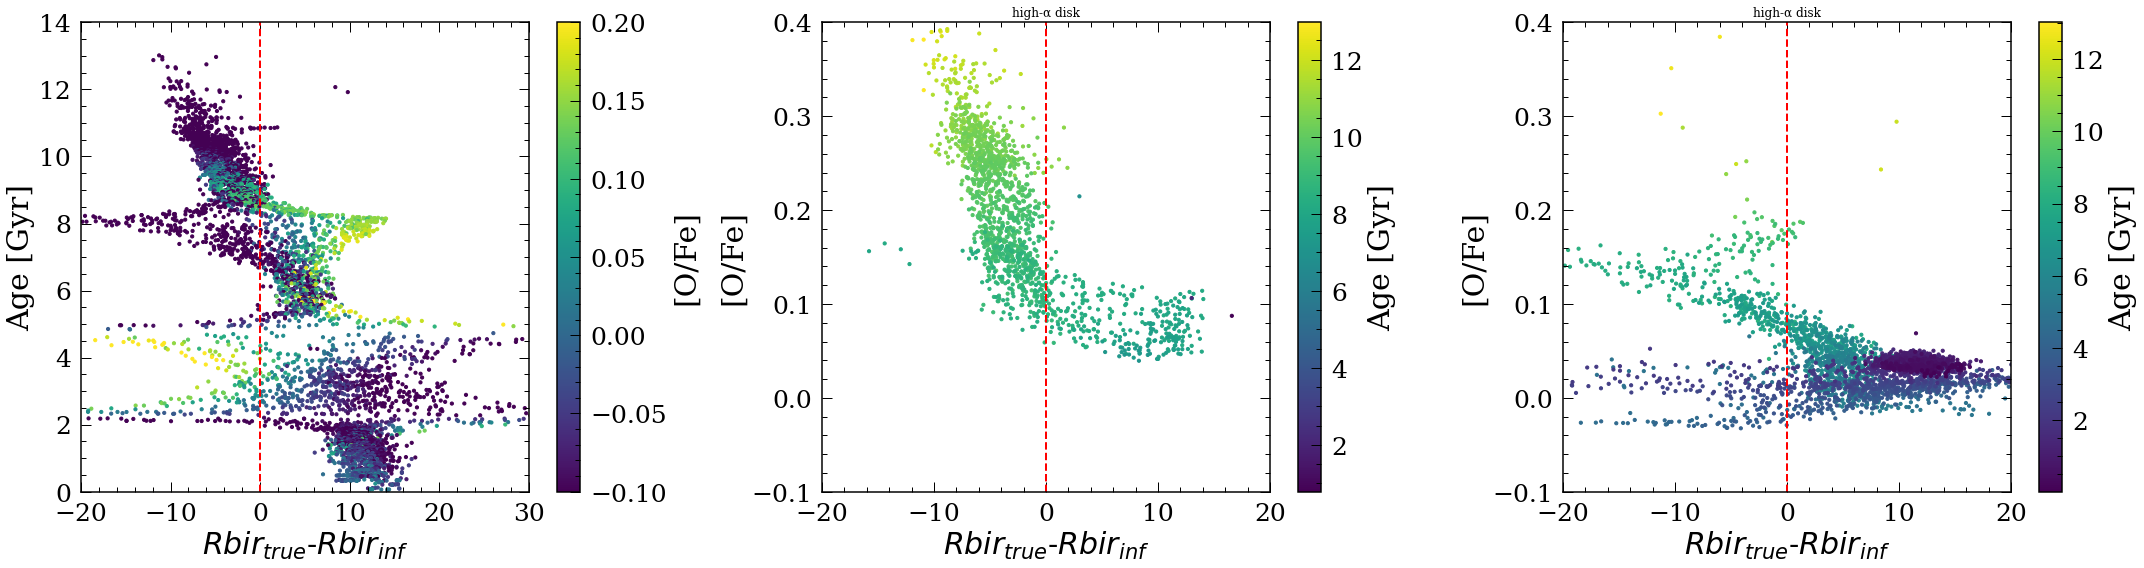

In [261]:
p=fitpoints([-0.8,0.6],[0.25,-0.06])
data_sr=data[m_sr]
data_sr['hi_low']=data_sr['ofe_scale']-p(data_sr['feh_scale'])>0

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.scatter(r_birth_true-rbirth_inf, data_sr['age'].values, s=10, 
            c = data_sr['feh_scale'].values, vmin=-0.1,vmax=0.2)
plt.plot([0,0],[0,14],'r--')
plt.xlim([-20,30])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.ylim([0,14])
plt.ylabel('Age [Gyr]')
cbar = plt.colorbar()
cbar.set_label('[O/Fe]',labelpad = 5)

plt.subplot(1,3,2)
m_ha=(data_sr['hi_low']==1)
data_ha=data_sr.loc[m_ha]
plt.scatter(r_birth_true[m_ha]-rbirth_inf[m_ha], data_ha['ofe_scale'].values, s=10, 
            c = data_ha['age'].values)
plt.xlim([-20,20])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.plot([0,0],[-0.1,0.4],'r--')
plt.ylim([-0.1,0.4])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)
plt.title('high-α disk')

plt.subplot(1,3,3)
m_la=(data_sr['hi_low']==0)
data_la=data_sr.loc[m_la]
plt.scatter(r_birth_true[m_la]-rbirth_inf[m_la], data_la['ofe_scale'].values, s=10, 
            c = data_la['age'].values)
plt.xlim([-20,20])
plt.xlabel('$Rbir_{true}$-$Rbir_{inf}$')
plt.plot([0,0],[-0.1,0.4],'r--')
plt.ylim([-0.1,0.4])
plt.ylabel('[O/Fe]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)
plt.title('high-α disk')
plt.tight_layout()

## now use ofe

0.040843815511100945


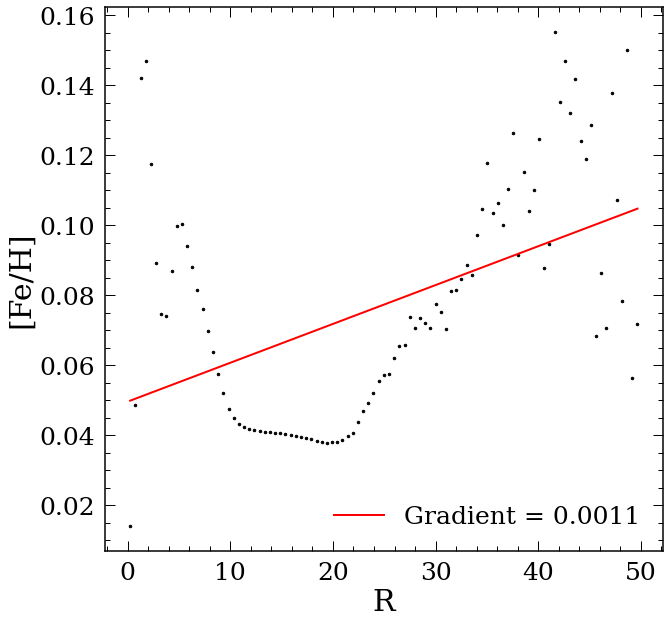

In [172]:
radtotest=1
# present day metallicity gradient
p=calc_dfedr_SR(data['ofe_scale'].values,data['R'].values,plotpoints=True)

feh_sr=data['ofe_scale'][m_sr].values
r_sr=data['R'][m_sr].values

srm=(abs(data['R']-SolarRad)<radtotest)
feh_p = np.median(data['ofe_scale'][srm])
print(feh_p)



In [167]:
import emcee
import corner
# test for the first agebin
infer_slopes_ofe=np.zeros((numbofbins,3))
infer_feh_ofe=np.zeros((numbofbins,3))
int_disp_ofe=np.zeros((numbofbins,3))
nwalkers = 64
for i in trange(len(agebin)-1):
    m=(ages_sr>=agebin[i])&(ages_sr<=agebin[i+1])
    
    # get initial guess
    feh_sample, ages_sample = feh_sr[m], ages_sr[m]
    slope0 = getfeh_slope(np.mean(ages_sample))
    feh0 = getfeh_sr(np.mean(ages_sample))-slope0*SolarRad

    sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(feh_sample, ages_sample))
    p0 = np.array([slope0, feh0, np.log(0.03)])
    p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
    pos, _, _ = sampler_scatter.run_mcmc(p0, 1000)
    sampler_scatter.reset()
    sampler_scatter.run_mcmc(pos, 6000)
    samples_scatter = sampler_scatter.flatchain
    #tau = sampler_scatter.get_autocorr_time(c=4)

    mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
    infer_slopes_ofe[i,:] = mcmc[1], q[0], q[1]
    
    mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
    infer_feh_ofe[i,:] = infer_slopes[i,0]*SolarRad+mcmc[1], np.sqrt(infer_slopes[i,1]**2+q[0]**2), np.sqrt(infer_slopes[i,2]**2+q[1]**2)
    
    mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
    int_disp_ofe[i,:] = mcmc[1], q[0], q[1]



100%|██████████| 6/6 [13:06<00:00, 131.02s/it]


[0.00724124 0.01201695 0.02072237 0.02676505 0.02019104 0.03913726]


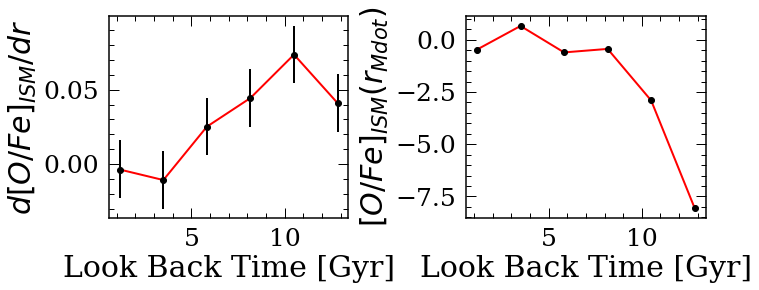

In [168]:
from scipy.interpolate import interp1d
# plot the results
print(np.exp(int_disp_ofe[:,0]))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
minagebin=min(agebin[:-1]+np.diff(agebin)[0]/2)
maxagebin=max(agebin[:-1]+np.diff(agebin)[0]/2)
pslope=interp1d(agebin[:-1]+np.diff(agebin)[0]/2,infer_slopes_ofe[:,0])
plt.errorbar((agebin[:-1]+np.diff(agebin)[0]/2),infer_slopes_ofe[:,0],
             yerr=[infer_slopes_ofe[:,1],infer_slopes_ofe[:,2]],fmt='ko')
plt.plot(np.linspace(minagebin,maxagebin,100),pslope(np.linspace(minagebin,maxagebin,100)),'r-')

plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$d[O/Fe]_{ISM}/dr$')

plt.subplot(1,2,2)
pfeh=interp1d(agebin[:-1]+np.diff(agebin)[0]/2,infer_feh_ofe[:,0])
plt.errorbar((agebin[:-1]+np.diff(agebin)[0]/2),infer_feh_ofe[:,0],
             yerr=[infer_feh_ofe[:,1],infer_feh_ofe[:,2]],fmt='ko')
plt.plot(np.linspace(minagebin,maxagebin,100),pfeh(np.linspace(minagebin,maxagebin,100)),'r-')
plt.xlabel('Look Back Time [Gyr]')
plt.ylabel('$[O/Fe]_{ISM}(r_{Mdot})$')

plt.tight_layout()

In [173]:
# get birth radii this way and plot against real birth radii
rbirth_inf_ofe = np.zeros(len(ages_sr))
for i in range(len(ages_sr)):
    # get relation
    if ages_sr[i]<minagebin:
        m = infer_slopes_ofe[0,0]
        b = infer_feh_ofe[0,0]-m*SolarRad
    elif ages_sr[i]>maxagebin:
        m = infer_slopes_ofe[-1,0]
        b = infer_feh_ofe[-1,0]-m*SolarRad
    else:
        m = pslope(ages_sr[i])
        b = pfeh(ages_sr[i])-m*SolarRad
    rbirth_inf_ofe[i] = (feh_sr[i]-b)/m



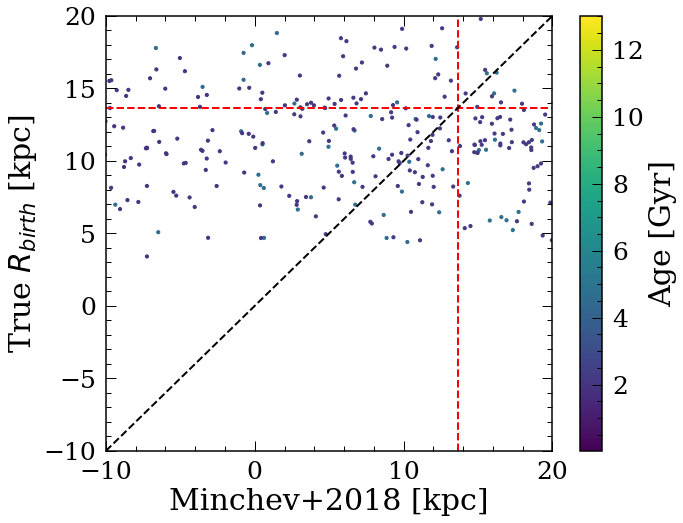

In [199]:
plt.figure(figsize=(10,8))
plt.scatter(rbirth_inf_ofe, r_birth_true, s=10, c = ages_sr)
plt.plot([SolarRad,SolarRad],[-10,20],'r--')
plt.plot([-10,20],[SolarRad,SolarRad],'r--')
plt.plot([-10,20],[-10,20],'k--')
plt.xlim([-10,20])
plt.ylim([-10,20])
plt.xlabel('Minchev+2018 [kpc]')
plt.ylabel('True $R_{birth}$ [kpc]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)

## compare the two Rbirth inf

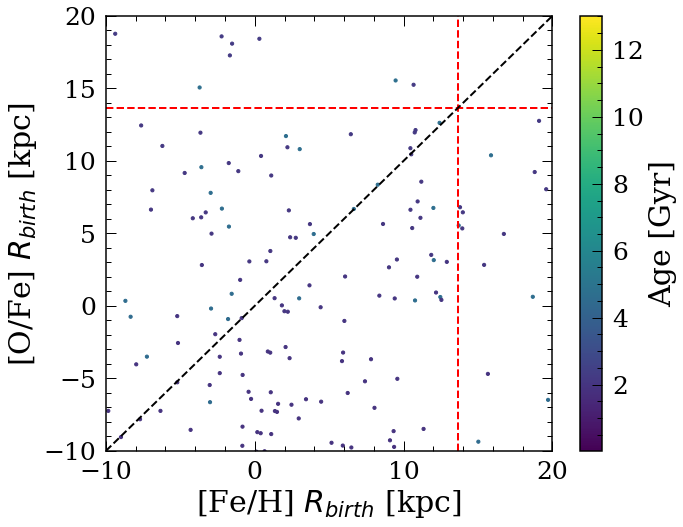

In [203]:
plt.figure(figsize=(10,8))
plt.scatter(rbirth_inf, rbirth_inf_ofe, s=10, c = ages_sr)
plt.plot([SolarRad,SolarRad],[-10,20],'r--')
plt.plot([-10,20],[SolarRad,SolarRad],'r--')
plt.plot([-10,20],[-10,20],'k--')
plt.xlim([-10,20])
plt.ylim([-10,20])
plt.xlabel('[Fe/H] $R_{birth}$ [kpc]')
plt.ylabel('[O/Fe] $R_{birth}$ [kpc]')
cbar = plt.colorbar()
cbar.set_label('Age [Gyr]',labelpad = 5)